# Colab Toy Model Test Workflow

In [1]:
import math
import os
from random import shuffle
import glob
import random 
import pandas as pd
import numpy as np

import cv2
import keras

from PIL import Image
from matplotlib import pyplot as plt
from skimage.io import imshow
from PIL import Image

from tensorflow.keras.utils import normalize
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.utils import to_categorical


import segmentation_models as sm

from tensorflow.keras import callbacks
from sklearn.model_selection import train_test_split

# Segmentation Models
import segmentation_models as sm
from segmentation_models import Unet
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score
from tensorflow.keras.metrics import MeanIoU

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras import backend as K


2023-12-09 15:45:36.682784: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-09 15:45:37.119963: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-09 15:45:37.164300: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/gargantua/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/cv2/../../lib64

Segmentation Models: using `keras` framework.


## Data loading 

In [2]:
# image and label directories paths
image_folder = "/home/gargantua/code/TigerManon/08-Palette/ai4mars-dataset-merged-0.1/msl/images/edr"
label_folder = "/home/gargantua/code/TigerManon/08-Palette/ai4mars-dataset-merged-0.1/msl/labels/train"

In [3]:
#Image.open("/home/gargantua/code/TigerManon/08-Palette/ai4mars-dataset-merged-0.1/msl/images/edr/NLA_397681372EDR_F0020000AUT_04096M1.JPG")


### Random visualization of overlapped image and label

In [4]:
"""
edr_files = os.listdir(image_folder)
trlab_files = os.listdir(label_folder)

X = []
y = []
c = 0

# preparing X and y
for lab_name in trlab_files:
    img_name = lab_name[:-4] + ".JPG"
    
    if img_name in edr_files:
        
        img_path = os.path.join(image_folder, img_name)
        img_arr = cv2.imread(img_path)
        img_arr = cv2.resize(img_arr, dsize = (256, 256))
        
        lab_path = os.path.join(label_folder, lab_name)
        lab_arr = cv2.imread(lab_path, 0)
        lab_arr = cv2.resize(lab_arr, (256, 256), interpolation = cv2.INTER_NEAREST)
        
        X.append(img_arr)
        y.append(lab_arr)
        
    c += 1
    if c >= 300:
        break
        
X = np.asarray(X, dtype = np.float32) / 255.0
y = np.array(y, dtype = np.uint8)

# 0 - soil
# 1 - bedrock
# 2 - sand
# 3 - big rock
# 255 -> 4 - NULL (no label)


# keeping integer values in labels will help us in segmentation task (UNet)
y[y==255] = 4

print(X.shape, y.shape)
"""

'\nedr_files = os.listdir(image_folder)\ntrlab_files = os.listdir(label_folder)\n\nX = []\ny = []\nc = 0\n\n# preparing X and y\nfor lab_name in trlab_files:\n    img_name = lab_name[:-4] + ".JPG"\n    \n    if img_name in edr_files:\n        \n        img_path = os.path.join(image_folder, img_name)\n        img_arr = cv2.imread(img_path)\n        img_arr = cv2.resize(img_arr, dsize = (256, 256))\n        \n        lab_path = os.path.join(label_folder, lab_name)\n        lab_arr = cv2.imread(lab_path, 0)\n        lab_arr = cv2.resize(lab_arr, (256, 256), interpolation = cv2.INTER_NEAREST)\n        \n        X.append(img_arr)\n        y.append(lab_arr)\n        \n    c += 1\n    if c >= 300:\n        break\n        \nX = np.asarray(X, dtype = np.float32) / 255.0\ny = np.array(y, dtype = np.uint8)\n\n# 0 - soil\n# 1 - bedrock\n# 2 - sand\n# 3 - big rock\n# 255 -> 4 - NULL (no label)\n\n\n# keeping integer values in labels will help us in segmentation task (UNet)\ny[y==255] = 4\n\nprint(X

In [5]:
"""
n = random.randint(0, len(X))
print(np.unique(y[n]))

plt.figure(figsize = (10, 10))

plt.imshow(X[n])
plt.imshow(y[n], alpha = 0.1)

plt.show()
"""

'\nn = random.randint(0, len(X))\nprint(np.unique(y[n]))\n\nplt.figure(figsize = (10, 10))\n\nplt.imshow(X[n])\nplt.imshow(y[n], alpha = 0.1)\n\nplt.show()\n'

In [6]:
#y[255]

In [7]:
#print(np.unique(y[255]))

In [8]:
# The 3 channels of each image are the same
#print(X[0][:,:,0])

In [9]:
#print(X[0][:,:,1])

In [10]:
#print(X[0][:,:,2])

### Build a customized data generator

In [11]:
# image and label directories paths
#dataset_path = "/home/gargantua/code/TigerManon/08-Palette/ai4mars-dataset-merged-0.1/msl"
#image_folder = "/home/gargantua/code/TigerManon/08-Palette/ai4mars-dataset-merged-0.1/msl/images/edr"
#label_folder = "/home/gargantua/code/TigerManon/08-Palette/ai4mars-dataset-merged-0.1/msl/labels/train"


In [12]:
#img_names = sorted(os.listdir(image_folder))
#lab_names = sorted(os.listdir(label_folder))

In [13]:
#img_names[0]

In [14]:
#lab_names[1]

In [59]:
# Define a customized data generator
class UnetDataGenerator(keras.utils.Sequence):
    def __init__(self, image_folder, label_folder, input_shape, batch_size, num_classes, subfolder, split_percent):
        self.image_folder       = image_folder
        self.label_folder       = label_folder
        self.input_shape        = input_shape
        self.batch_size         = batch_size
        self.num_classes        = num_classes
        self.subfolder          = subfolder
        self.split_percent      = split_percent
        self.path_df            = self.make_df()
        self.split_df()

    def __len__(self):
        print("Length of generator:", len(self.path_df))
        return math.ceil(len(self.path_df) / float(self.batch_size))
    
    def make_df(self):      
        img_list = [f for f in os.listdir(self.image_folder) if f.endswith('.JPG')]
        lab_list = [f for f in os.listdir(self.label_folder) if f.endswith('.png')]
        
        path_df = pd.DataFrame(columns=["image_path","label_path"])
        
        for label_name in lab_list:
            image_name = label_name.replace('.png', '.JPG')
            if image_name in img_list:
                path_df = path_df.append({
                    "image_path": os.path.join(self.image_folder, image_name),
                    "label_path": os.path.join(self.label_folder, label_name)
                }, ignore_index=True)
        return path_df
    
    def split_df(self):
        if self.subfolder == "train":
            self.path_df = self.path_df.iloc[:int(len(self.path_df) * self.split_percent)]
        elif self.subfolder == "val":
            self.path_df = self.path_df.iloc[int(len(self.path_df) * self.split_percent):]
    
    
    def __getitem__(self, index):
        input_images  = []
        output_targets = []

        #-------------------------------#
        #   Calculate start indice and end indice of the batch
        #-------------------------------#  
        start = index * self.batch_size
        end = min((index + 1) * self.batch_size, len(self.path_df)) # Make sure that we can load all the data of the last batch

        for i in range(start, end):  
            
            #-------------------------------#
            #   Get image path and label path of each batch from path_df
            #-------------------------------#                     
            jpg = self.path_df.iloc[i]["image_path"]
            png = self.path_df.iloc[i]["label_path"]
                
            #-------------------------------#
            #   Transform images and labels to numpy array, resize them
            #   Set the background label to 4
            #-------------------------------#

            jpg = cv2.imread(jpg)           
            png = cv2.imread(png,0)
                
            jpg = cv2.resize(jpg, dsize = (int(self.input_shape[0]), int(self.input_shape[1])))
            png = cv2.resize(png, dsize = (int(self.input_shape[0]), int(self.input_shape[1])), 
                                      interpolation = cv2.INTER_NEAREST)

            png[png == 255] = 4

            #-------------------------------------------------------#
            #   One hot encode the labels
            #-------------------------------------------------------#
                
            seg_labels = np.eye(self.num_classes)[png.reshape([-1])]                
            seg_labels = seg_labels.reshape((int(self.input_shape[0]), int(self.input_shape[1]), self.num_classes))

            input_images.append(jpg)
            output_targets.append(seg_labels)

        input_images = np.asarray(input_images)
        output_targets = np.array(output_targets)

        
        return input_images, output_targets


In [16]:
                
            #mask_list = []
            #for n in range(0, self.num_classes ):  # Assurez-vous que les classes commencent à 0
            #    mask = (png == i).astype(np.float32)  # Crée un masque pour chaque classe
            #    mask_list.append(mask)

            ## Empilage des masques pour former 5 canaux
            #seg_labels = np.stack(mask_list, axis=-1)
                
            #import pdb
            #pdb.set_trace()

In [17]:
#lab_files[255]

In [18]:
#lab_255 = os.path.join(dataset_path, "labels/train", lab_files[255])

In [19]:
#cv2.imread(lab_255).shape

In [20]:
#cv2.imread(lab_255,0).shape

In [21]:
#cv2.imread(lab_255,0).max()

In [22]:
#cv2.imread(lab_255,0).min()

In [23]:
#cv2.imread(lab_255,0).mean()

In [24]:
#np.unique(cv2.imread(lab_255,0))

In [25]:
#array_lab = cv2.imread(lab_255,0)

In [26]:
#resize_lab = cv2.resize(array_lab, dsize = (256, 256))

In [27]:
#resize_lab.max()

In [28]:
#lab_arr = cv2.resize(array_lab, (256, 256), interpolation = cv2.INTER_NEAREST)

In [29]:
#lab_arr.max()

In [30]:
#np.unique(lab_arr)

In [31]:
#lab_arr[lab_arr == 255] = 4

In [32]:
#lab_arr.max()

In [33]:
#np.unique(lab_arr)

In [34]:
#reshaped = png.reshape([-1])

In [35]:
#np.unique(reshaped)


In [36]:
#np.eye(4)[reshaped]

In [37]:
#png = cv2.imread(lab_255,0)

In [38]:
#np.unique(png)

In [39]:
#png_resize  = cv2.resize(png, dsize = (256,256))

In [40]:
#np.unique(png_resize)

In [41]:
#resize_2 = cv2.resize(png, dsize = (256,256),interpolation = cv2.INTER_NEAREST)

In [42]:
#np.unique(resize_2)

In [43]:
#resize_2[resize_2 == 255] = 4

In [44]:
#np.unique(resize_2)

In [45]:
#reshape_2 = resize_2.reshape([-1])

In [46]:
#np.unique(reshape_2)

In [47]:
#ohe = np.eye(5)[reshape_2]

In [48]:
#ohe.shape

In [49]:
#np.unique(ohe)

In [50]:
#ohe.reshape(256,256,5)

### Base Model building

In [51]:
def Unet_model():
    """
    Initialize the U-Net model
    """
    #################
    #    Params    #
    #################

    n_classes=5
    height=256
    width=256
    channels=3
    inputs = Input((height, width, channels))

    ############################
    # Down Sampling - Encoding #
    ############################

    conv_1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    conv_1 = Dropout(0.1)(conv_1)
    conv_1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_1)
    pool_1 = MaxPooling2D((2, 2))(conv_1)

    conv_2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool_1)
    conv_2 = Dropout(0.1)(conv_2)
    conv_2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_2)
    pool_2 = MaxPooling2D((2, 2))(conv_2)

    conv_3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool_2)
    conv_3 = Dropout(0.1)(conv_3)
    conv_3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_3)
    pool_3 = MaxPooling2D((2, 2))(conv_3)

    conv_4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool_3)
    conv_4 = Dropout(0.1)(conv_4)
    conv_4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_4)
    pool_4 = MaxPooling2D(pool_size=(2, 2))(conv_4)

    conv_5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool_4)
    conv_5 = Dropout(0.2)(conv_5)
    conv_5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_5)

    ############################
    #  Up Sampling - Decoding  #
    ############################

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv_5)
    u6 = concatenate([u6, conv_4])
    conv_6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    conv_6 = Dropout(0.2)(conv_6)
    conv_6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv_6)
    u7 = concatenate([u7, conv_3])
    conv_7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    conv_7 = Dropout(0.1)(conv_7)
    conv_7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv_7)
    u8 = concatenate([u8, conv_2])
    conv_8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    conv_8 = Dropout(0.2)(conv_8)
    conv_8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(conv_8)
    u9 = concatenate([u9, conv_1], axis=3)
    conv_9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    conv_9 = Dropout(0.1)(conv_9)
    conv_9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_9)

    ################
    # Output Layer #
    ################

    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(conv_9)

    ########################
    # Model initialization #
    ########################

    model = Model(inputs=[inputs], outputs=[outputs])
    
    model.summary()
    
    return model

    

In [52]:
# Initializing and compiling model
model = Unet_model()
model.compile(optimizer='adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])

2023-12-09 15:45:40.572983: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/gargantua/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/cv2/../../lib64:
2023-12-09 15:45:40.573139: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-12-09 15:45:40.573208: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Jinjin): /proc/driver/nvidia/version does not exist
2023-12-09 15:45:40.574284: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropri

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

                                                                                                  
 dropout_7 (Dropout)            (None, 128, 128, 32  0           ['conv2d_14[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_15 (Conv2D)             (None, 128, 128, 32  9248        ['dropout_7[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_transpose_3 (Conv2DTran  (None, 256, 256, 16  2064       ['conv2d_15[0][0]']              
 spose)                         )                                                                 
                                                                                                  
 concatena

### Base Model Training

In [53]:
# Split train and validation datasets
#X_train, X_test, y_train, y_test = train_test_split(#X,#y, output_targets, test_size = 0.2, random_state = 42)

In [54]:
#len(lab_names)

In [55]:
#len(img_names)

#### Build the train and val sub folders

In [56]:
# Some inputs
#image_size = (256,256,3)
batch_size = 16
num_classes = 5
input_shape = (256,256,3)
split_percent = 0.8

In [60]:
# image and label directories paths
#dataset_path = "/home/gargantua/code/TigerManon/08-Palette/ai4mars-dataset-merged-0.1/msl"
image_folder = "/home/gargantua/code/TigerManon/08-Palette/ai4mars-dataset-merged-0.1/msl/images/edr"
label_folder = "/home/gargantua/code/TigerManon/08-Palette/ai4mars-dataset-merged-0.1/msl/labels/train"

In [61]:
# Train dataset generator and validation dataset generator
traingen = UnetDataGenerator(image_folder,
                             label_folder,
                             input_shape,                        
                             batch_size,
                             num_classes,
                             "train",
                             split_percent)

valgen = UnetDataGenerator(image_folder,
                           label_folder,
                           input_shape,                        
                           batch_size,
                           num_classes,
                           "val",
                           split_percent)


/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({


/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({


/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({


/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({


/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({


/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({


/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({


/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({


/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({


/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({


/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({


/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({


/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({


/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({


/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({


/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({


/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({


/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({


/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({


/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({


/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({


/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({


/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({


/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({


/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({


/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({


/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({


/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({


/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({


/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({


/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({


/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({


/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({


/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({


/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({


/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({


/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({


/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({


/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({


/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({


/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({


/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({


/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({


/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({


/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({


/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({


/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({


/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({


/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({


/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({


/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({


/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({


/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({


/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
/tmp/ipykernel_2630/1896004809.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({


In [62]:
%%time
es = callbacks.EarlyStopping(patience=2,restore_best_weights=True)
#modelCheckpoint = callbacks.ModelCheckpoint("{}.h5".format('First_model'), monitor="val_loss", verbose=0, save_best_only=False)


history = model.fit(traingen,
          validation_data=valgen,
          epochs=1,
          callbacks=[es],
          verbose=1)  

Length of generator: 3213
Length of generator: 12851
Length of generator: 12851
Length of generator: 12851
804/804 [==============================] - ETA: 0s - loss: 1.1563 - iou_score: 0.2526Length of generator: 3213
Length of generator: 3213
Length of generator: 3213
Length of generator: 3213
804/804 [==============================] - 1388s 2s/step - loss: 1.1563 - iou_score: 0.2526 - val_loss: 0.9600 - val_iou_score: 0.3342
CPU times: user 2h 13min 51s, sys: 2min 3s, total: 2h 15min 54s
Wall time: 23min 8s


In [66]:
history.history

{'loss': [1.1562952995300293],
 'iou_score': [0.2526222765445709],
 'val_loss': [0.9600193500518799],
 'val_iou_score': [0.3342071771621704]}

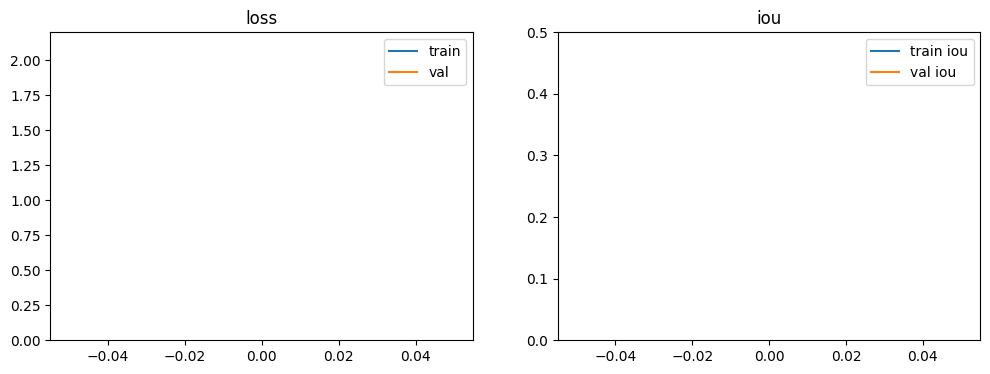

In [65]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label = 'train' + exp_name)
    ax1.plot(history.history['val_loss'], label = 'val' + exp_name)
    ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['iou_score'], label='train iou'  + exp_name)
    ax2.plot(history.history['val_iou_score'], label='val iou'  + exp_name)
    ax2.set_ylim(0, 0.5)
    ax2.set_title('iou')
    ax2.legend()
    plt.show()
    
plot_history(history)